<a href="https://colab.research.google.com/github/UsagiUG/PCD_Assignment01/blob/main/PCD_Assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import files
from PIL import Image
import numpy as np

uploaded = files.upload()  # pick an image



Saving Screenshot (19).png to Screenshot (19).png


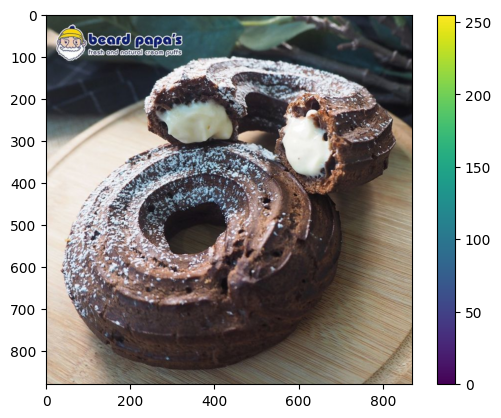

In [23]:
# Open image with PIL and convert to NumPy array
donut_img = Image.open("Screenshot (19).png")
donut_arr = np.array(donut_img)

import matplotlib.pyplot as plt

plt.imshow(donut_arr)
plt.colorbar()
plt.show()

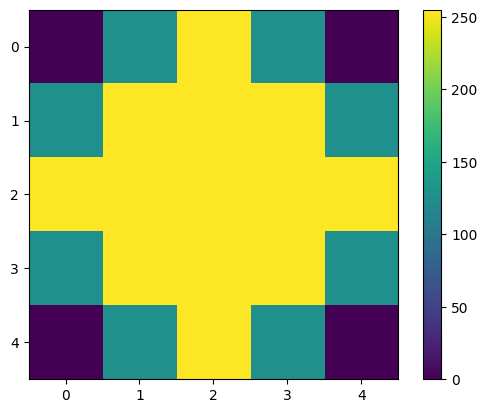

In [24]:
import numpy as np

# Example: 5x5 grayscale image
gray_img = np.array([
    [0, 128, 255, 128, 0],
    [128, 255, 255, 255, 128],
    [255, 255, 255, 255, 255],
    [128, 255, 255, 255, 128],
    [0, 128, 255, 128, 0]
])

import matplotlib.pyplot as plt

plt.imshow(gray_img)
plt.colorbar()
plt.show()

Generic Downsample code:

In [25]:
def resize(length1, length2, ratio):
  return round(length1 * ratio), round(length2 * ratio)

import math

#Calculating block-of-pixel's size to be processed.
#Use ceil() if the last block won't be out of bounds,
#else subtract 1 from the ceil()
def block_size(h, new_h, w, new_w):
  block_h = math.ceil(h / new_h)
  block_w = math.ceil(w / new_w)
  if block_h * (new_h - 1) >= h:
    block_h -= 1
  if block_w * (new_w - 1) >= w:
    block_w -= 1
  return block_h, block_w

def downsample(img, ratio, reduce_fn):
  h, w = img.shape[:2]
  new_h, new_w = resize(h, w, ratio)
  new_img = np.zeros((new_h, new_w, *img.shape[2:]), dtype=np.uint8)
  block_h, block_w = block_size(h, new_h, w, new_w)
  for j in range(new_h):
    for i in range(new_w):
      x = (i+1)*block_w if i < new_w-1 else w
      y = (j+1)*block_h if j < new_h-1 else h
      block = img[j*block_h:y, i*block_w:x]
      new_img[j,i] = reduce_fn(block, axis=(0,1))
  return new_img

Downsample Max:

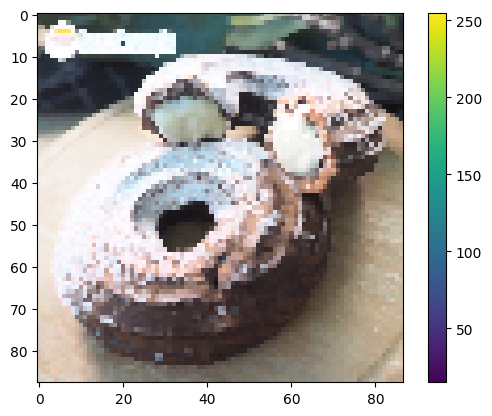

In [26]:
max_downsampled = downsample(donut_arr, 0.1, np.max)
plt.imshow(max_downsampled)
plt.colorbar()
plt.show()

Downsample Mean:

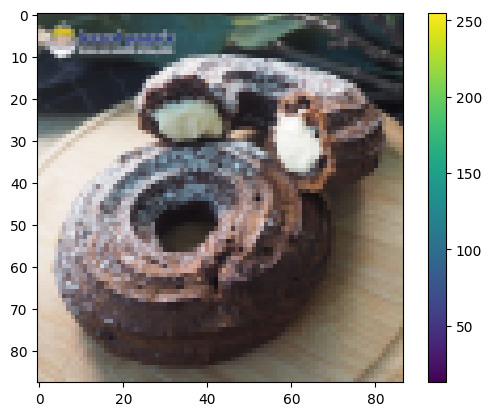

In [27]:
mean_downsampled = downsample(donut_arr, 0.1, np.mean)
plt.imshow(mean_downsampled)
plt.colorbar()
plt.show()

Downsample Median:

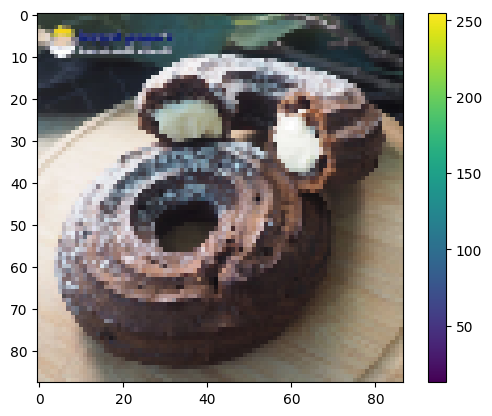

In [28]:
median_downsampled = downsample(donut_arr, 0.1, np.median)
plt.imshow(median_downsampled)
plt.colorbar()
plt.show()

Nearest Neighbor Upsample:

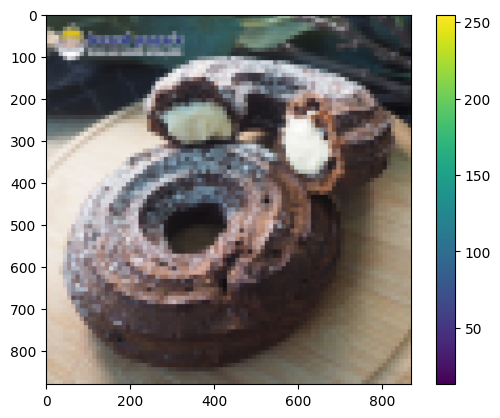

In [29]:
def nn_upsample(img, ratio):
  h, w = img.shape[:2]
  new_h, new_w = resize(h, w, ratio)
  real_h_ratio, real_w_ratio = new_h / h, new_w / w
  new_img = np.zeros((new_h, new_w, *img.shape[2:]), dtype=np.uint8)
  for j in range(new_h):
    for i in range(new_w):
      new_img[j,i] = img[int(j // real_h_ratio), int(i // real_w_ratio)]
  return new_img

nn_upsampled = nn_upsample(mean_downsampled, 10)
plt.imshow(nn_upsampled)#, cmap='Reds', vmin=0, vmax=255)
plt.colorbar()
plt.show()

Bilinear Upsample. Only accept round number for scale/ratio, float will be converted into int. Last column and row will be trimmed to simplify the formula, or else padding or linear interpolation is needed. For 5x5 image, the result of 1 row and 1 column trimming is going to be significant, but for normal image, this is insignificant:

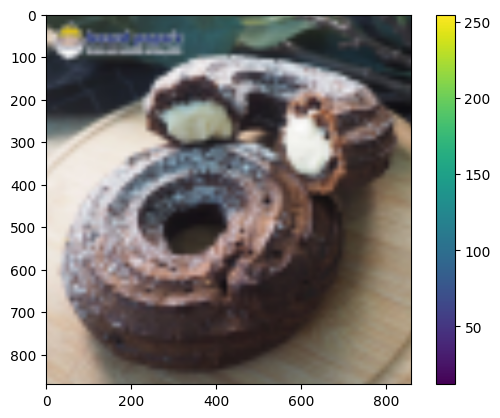

In [33]:
def bl_resize(h, w, ratio):
  return (h-1)*round(ratio), (w-1)*round(ratio)

def bl_upsample(img, ratio):
  h, w = img.shape[:2]
  new_h, new_w = bl_resize(h, w, ratio)
  ratio = round(ratio)
  new_img = np.zeros((new_h, new_w, *img.shape[2:]), dtype=np.uint8)
  # Last row and column trimmed, so h-1 and w-1
  for j in range(h-1):
    for i in range(w-1):
      x1, y1 = i*ratio, j*ratio
      x2, y2 = (i+1)*ratio, (j+1)*ratio
      divisor = 1 / ((x2-x1)*(y2-y1))
      neighbor_matrix = np.array([[img[j,i], img[j+1,i]],[img[j,i+1], img[j+1,i+1]]])
      for k in range(y1, y2):
        for l in range(x1, x2):
          row_vector = np.array([x2-l, l-x1])
          column_vector = np.array([[y2-k],[k-y1]])
          if img.ndim == 2:
            # For grayscale image
            new_img[k,l] = (divisor * row_vector @ neighbor_matrix @ column_vector).item()
          else:
            # For RGB
            for m in range(img.shape[2]):
              new_img[k,l,m] = (divisor * row_vector @ neighbor_matrix[:,:,m] @ column_vector).item()
  return new_img

bl_upsampled = bl_upsample(mean_downsampled, 10)
plt.imshow(bl_upsampled)
plt.colorbar()
plt.show()

Bicubic Upsample. :( Unfortunately, it is not completed yet. There is a logic somewhere that is wrong. So, below it is the PCD Class version of Bicubic Upsample:

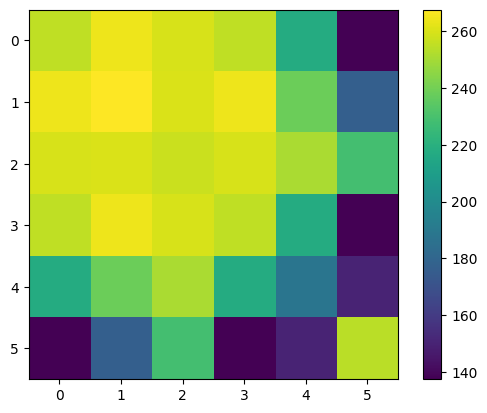

In [31]:
def bc_resize(h, w, ratio):
  return (h-3)*round(ratio), (w-3)*round(ratio)

def bc_upsample(img, ratio):
  h, w = img.shape[:2]
  new_h, new_w = bc_resize(h, w, ratio)
  ratio = round(ratio)
  # new_img = np.zeros((new_h, new_w, *img.shape[2:]), dtype=np.uint8)
  new_img = np.zeros((new_h, new_w, *img.shape[2:]))
  bicubic_matrix = np.array([[0, 2, 0, 0], [-1, 0, 1, 0], [2, -5, 4, -1], [-1, 3, -3, 1]])
  # Last row and column trimmed, so h-1 and w-1
  for j in range(1,h-2):
    for i in range(1,w-2):
      x1, y1 = (i-1)*ratio, (j-1)*ratio
      x2, y2 = i*ratio, j*ratio
      for k in range(y1, y2):
        for l in range(x1, x2):
          x_conv_result = np.zeros((4,1))
          for m in range(4):
            row_vector = np.array([1, l/ratio, (l/ratio)**2, (l/ratio)**3])
            column_vector = np.array([img[j-1+m, i-1:i+3]]).T
            x_conv_result[m] = 0.5 * row_vector @ bicubic_matrix @ column_vector
          row_vector = np.array([1, k/ratio, (k/ratio)**2, (k/ratio)**3])
          # new_img[k,l] = (np.clip(0.5 * row_vector @ bicubic_matrix @ x_conv_result, 0, 255).astype(np.uint8)).item()
          new_img[k,l] = (0.5 * row_vector @ bicubic_matrix @ x_conv_result).item()

  return new_img

bc_upsampled = bc_upsample(gray_img, 3)
plt.imshow(bc_upsampled)
plt.colorbar()
plt.show()

Bicubic Upsampling (PCD Class version). If The weight of distance 1 neighbor (d1) is 1 and distance 2 neighbor (d2) is 0. This becomes PCD Class version of Bilinear. So below this is PCD Class version of Bilinear:

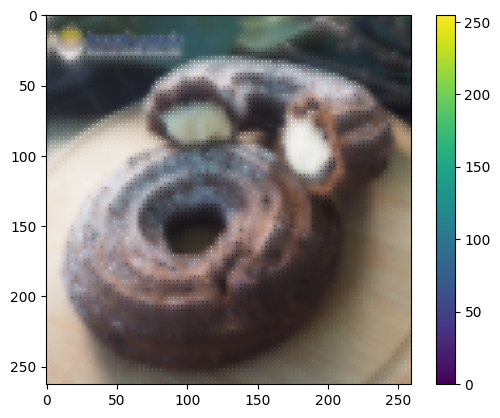

In [46]:
def bc_resize2(h, w, ratio):
  return h*ratio-1, w*ratio-1

def bc_upsample2(img,ratio,d1_weight,d2_weight):
  h, w = img.shape[:2]
  new_h, new_w = bc_resize2(h, w, ratio)
  new_img = np.full((new_h, new_w, *img.shape[2:]), -1)
  for j in range(0, new_h, ratio):
    for i in range(0, new_w, ratio):
      new_img[j,i] = img[int(j/ratio),int(i/ratio)]
  for j in range(new_h):
    for i in range(new_w):
      if np.all(new_img[j,i] == -1):
        d1_neighbor = 0
        d1_counter = 0
        d2_neighbor = 0
        d2_counter = 0
        for k, l in [(-1,-1), (-1,0), (-1,1),
                     (0,-1),          (0,1),
                     (1,-1),  (1,0),  (1,1)]:
          # checking out of bound
          if (0 < j+k < new_h) and (0 < i+l < new_w):
            if np.all(new_img[j+k, i+l] != -1):
              d1_neighbor += new_img[j+k, i+l]
              d1_counter += 1
        for k, l in [(-2,-2), (-2,-1), (-2,0), (-2,1), (-2,2),
                     (-1,-2),                          (-1,2),
                     (0,-2),                           (0,2),
                     (1,-2),                           (1,2),
                     (2,-2),  (2,-1),  (2,0),  (2,1),  (2,2)]:
          # checking out of bound
          if (0 < j+k < new_h) and (0 < i+l < new_w):
            if np.all(new_img[j+k, i+l] != -1):
              d2_neighbor += new_img[j+k, i+l]
              d2_counter += 1
        d1_math = d1_neighbor*d1_weight/d1_counter if d1_counter > 0 else 0
        d2_math = d2_neighbor*d2_weight/d2_counter if d2_counter > 0 else 0
        new_img[j,i] = np.round(d1_math + d2_math)
  new_img = new_img.astype(np.uint8)
  return new_img

bc_upsampled2 = bc_upsample2(mean_downsampled, 3, 0.7, 0.3)
plt.imshow(bc_upsampled2)
plt.colorbar()
plt.show()

In [ ]:
PCD Class version of Bilinear:

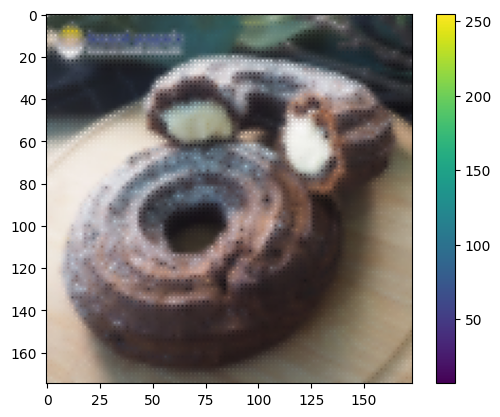

In [41]:
def bl_upsample2(img, ratio):
  return bc_upsample2(img, ratio, 1, 0)

bl_upsampled2 = bl_upsample2(mean_downsampled, 2)
plt.imshow(bl_upsampled2)
plt.colorbar()
plt.show()